# Bright SNe lightcurves
### Roy Williams
Grab some bright supernovae and plot them.  Demo of:
* /query/
* /lightcurves/

### Python (3 only) requirements - pip install
lasair, matplotlib


In [1]:
!pip install lasair

DEPRECATION: Loading egg at /Users/roywilliams/Library/Python/3.11/lib/python/site-packages/pyglet-2.0.10-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import sys, time
import matplotlib.pyplot as plt
import numpy as np

### Grab my Lasair API token
Get your Lasair token before you start. You can log into [Lasair](https://lasair.lsst.ac.uk) and click "My Profile"
at top right. Or use the command-line below.
```bash
curl --data "username=myusername&password=***********" https://lasair-ztf.lsst.ac.uk/api/auth-token/
```
Make a file called settings.py with a line like: `API_TOKEN = '0123456789abcdefxxxxxxxxxxxxxxxxxxxxxxxx'`

In [3]:
from lasair import LasairError, lasair_client as lasair
import settings

L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")

### Query for objects with the Sherlock classification SN

In [4]:
# Get the objects that are CURRENTLY brighter than mag 19 in both g and r, AND
# have more than 12 positive flux detections, AND sherlock thinks the object is
# a supernova. Must be a ZTF21 object.
conditions = """
sherlock_classifications.classification = "SN"
AND objects.gmag < 19 AND objects.rmag < 19
AND objects.ncandgp > 12
AND objects.objectId like 'ZTF23%'
"""

In [5]:
# Just join the objects table and the sherlock_classifications table, just
# pulling out the objectId.
rows = L.query(
    'objects.objectId',
    'objects, sherlock_classifications',
    conditions,
    limit=10)
objectIds = [row['objectId'] for row in rows]

### Plot lightcurve function

In [6]:
def plotLC(lightcurve):
    objectId = lightcurve['objectId']
    jd_now = time.time()/86400 + 40587.0 + 2400000.5
    color = {1:'green', 2:'red'}
    for fid in [1,2]:
        since = []
        magpsf = []
        sigmapsf = []
        for cand in lightcurve['candidates']:
            if cand['fid'] == fid:
                since.append(cand['jd'] - jd_now)
                magpsf.append(cand['magpsf'])
                sigmapsf.append(cand['sigmapsf'])
        plt.errorbar(since, magpsf, yerr=sigmapsf, c=color[fid])
        plt.xlabel("days before %.2f" % jd_now)
        plt.ylabel("psf mag")
        plt.title('https://lasair-ztf.lsst.ac.uk/objects/%s' % objectId)
    plt.gca().invert_yaxis()
    plt.show()

### Grab and plot the lightcurves

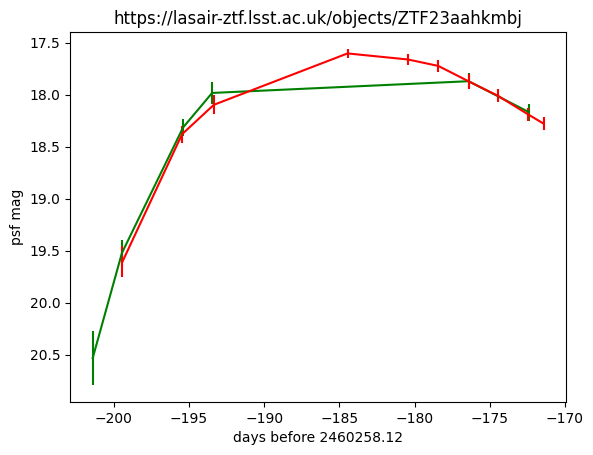

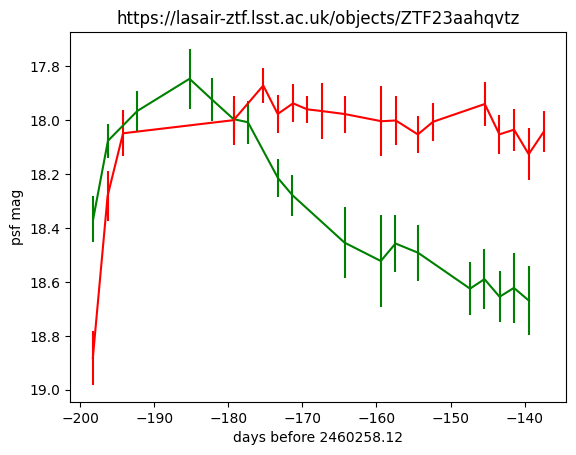

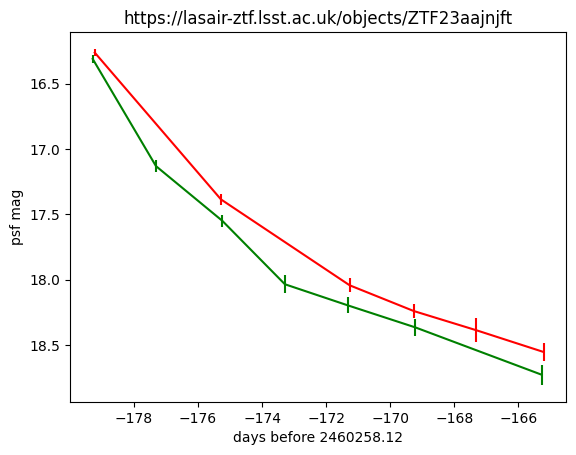

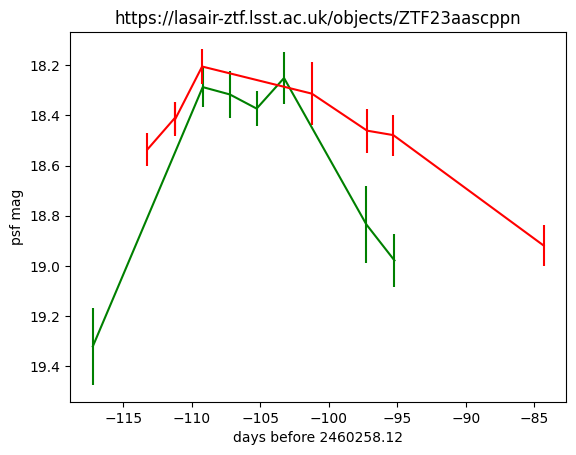

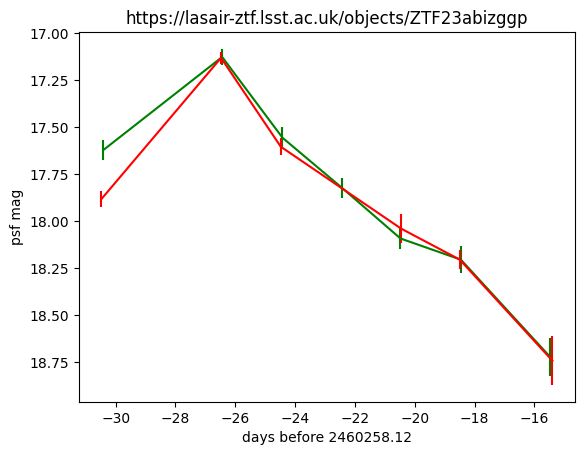

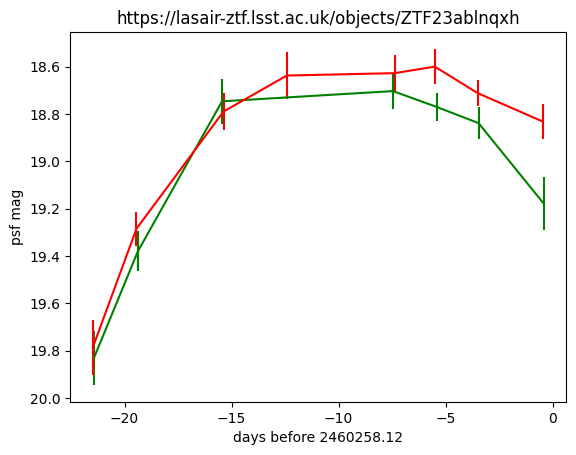

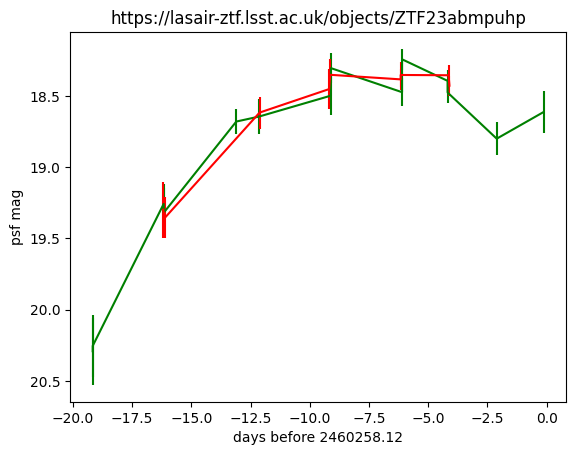

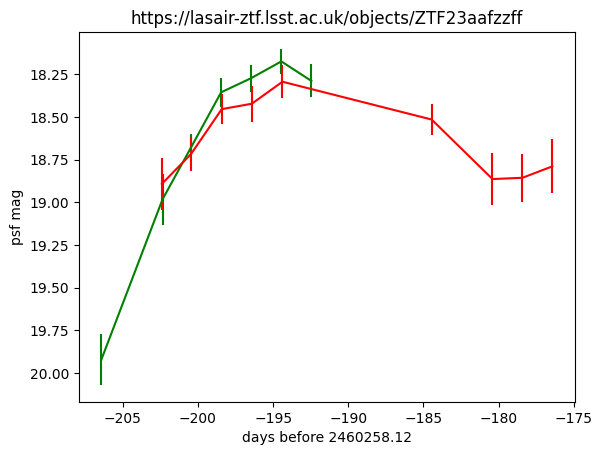

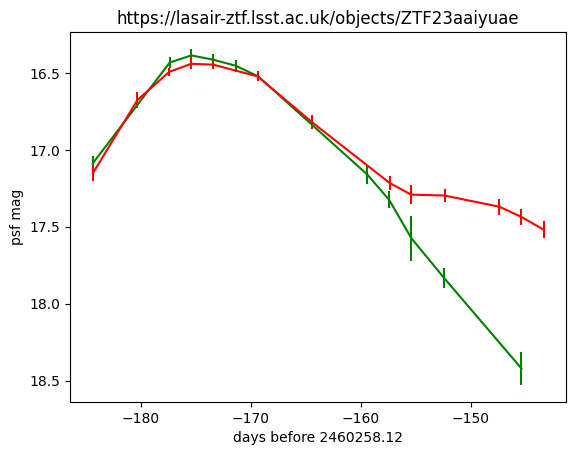

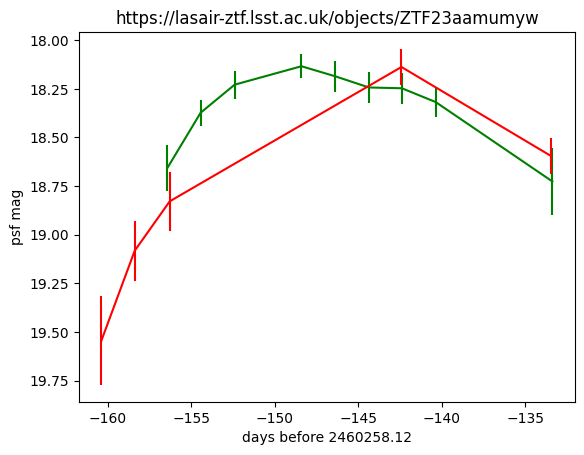

In [7]:
lcs = L.lightcurves(objectIds)

# Yes - I can get the object and lightcurves at the same time using objects function, but let's use the lightcurves function instead.
# In this case I have to split the candidates and non-candidates manually.
for obj, lc in zip(objectIds, lcs):
    detectionsOnly = []
    for l in lc['candidates']:
        if 'candid' in l.keys():
            detectionsOnly.append(l)

    plotLC({'objectId': obj, 'candidates': detectionsOnly})